In [12]:
import math
import numpy as np
import scipy.special as sp
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from numba import jit,int64,float64
import time
import scipy.optimize as sciopt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Color-blind friendly colors to plot:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

#Running the script with parameter definitions and functions:
%run fates_functions.py

In [9]:
# #Parameters - self-activation a, cross-repression r, decay k, noise alpha:
# a = np.array([0,0])
# r = np.array([1,1])
# k = np.array([1,1])
# alpha = np.array([0.5,0.5])
# #Hill coefficients:
# n = np.array([[4,4],[4,4]])
# theta = np.array([[0.5,0.5],[0.5,0.5]])

# #The total time and dt::
# T = 20
# dt = 0.005
# #Other time-related variables related to these two:
# Nt = int(T/dt)
# sqrt_dt = np.sqrt(dt)
# TimeRange = np.arange(0,T,dt)
# # #This is to calculate the dynamic threshold moving average:
# # timeBase = 2*int(Nt/100)
# # #Time to plot utility against:
# # time_trunc = TimeRange[int((timeBase/2)-1):-int(timeBase/2)]

# #Let's call num_traj the number of trajectories:
# num_traj = 10000

# #The initial conditions:
# x0 = np.zeros((2,num_traj))
# #Uniform around mean:
# init_bias = 0
# x0[0,:] = init_bias*np.ones(num_traj)

# #The threshold above which we say x_i is high:
# thresh = np.array([0.8,0.8])

# #Color-blind friendly colors to plot:
# CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [10]:
# #Self-activation:
# @jit(nopython=True)
# def activation(x,a,n,theta):
#     if (x>=0):
#         return (a*x**n)/(x**n + theta**n)
#     else:
#         return 0

# #Cross-inhibition
# @jit(nopython=True)
# def repression(x,r,n,theta):
#     if (x>0):
#         return (r*theta**n)/(x**n + theta**n)
#     else:
#         return 0

# #Bias (for external signals):
# @jit(nopython=True)
# def ext_bias(x1,x2,t):
# #     return (x1-x2,x2-x1)
#     temp = 0
#     return (temp,0)
    
# #This solves the system fwd using simple Euler-Maruyama:
# @jit(nopython=True)
# def Solver(initial,a,r,k,n,theta,alpha):
#     final = np.empty((2,num_traj,Nt))
#     final[:,:,0] = initial
#     #Solving the system forward in time:
#     for i in range(num_traj):
#         for t in range(1,Nt):
#             #Equation for first species:
#             temp = np.sqrt(np.maximum(final[0,i,t-1],0.01))
#             noise = rand.normalvariate(0,alpha[0]*temp)
#             final[0,i,t] = final[0,i,t-1] + dt*(activation(final[0,i,t-1],a[0],n[0,0],theta[0,0]) \
#                                                + repression(final[1,i,t-1],r[0],n[1,0],theta[1,0]) \
#                                                - k[0]*final[0,i,t-1] + ext_bias(final[0,i,t-1],final[1,i,t-1],t)[0]) \
#                                                 + sqrt_dt*noise
#             #Equation for second:
#             temp = np.sqrt(np.maximum(final[1,i,t-1],0.01))
#             noise = rand.normalvariate(0,alpha[1]*temp)
#             final[1,i,t] = final[1,i,t-1] + dt*(activation(final[1,i,t-1],a[1],n[1,1],theta[1,1]) \
#                                                + repression(final[0,i,t-1],r[1],n[0,1],theta[0,1]) \
#                                                - k[1]*final[1,i,t-1] + ext_bias(final[0,i,t-1],final[1,i,t-1],t)[1]) \
#                                                 + sqrt_dt*noise
#     return final

# #Classifier:
# # @jit(nopython=True)
# def fate_classifier(traj,thresh):
#     #Stability factor of trajectories:
#     cross_flags = np.zeros((2,num_traj))
#     cross_times = np.ones((2,num_traj))*Nt
#     for axis_idx in range(2):
#         #Axis crossings:
#         for traj_idx in range(num_traj):
#             if (np.size(np.where(traj[axis_idx,traj_idx]>thresh[axis_idx])[0]) != 0):
#                 cross_flags[axis_idx,traj_idx] = 1
#                 cross_times[axis_idx,traj_idx] = np.where(traj[axis_idx,traj_idx]>thresh[axis_idx])[0][0]
                    
#     #Stability factor: after the threshold is crossed, how much time the traj spends above it:
#     stability_factrs = np.zeros((2,num_traj))
#     for axis_idx in range(2):
#         for traj_idx in range(num_traj):
# #             if (cross_flags[axis_idx,traj_idx]==0):
# #                 stability_factrs[axis_idx,traj_idx] = -1
#             if (cross_flags[axis_idx,traj_idx]==1):
#                 stability_factrs[axis_idx,traj_idx] = np.sum(traj[axis_idx,traj_idx,int(cross_times[axis_idx,traj_idx]):]>thresh[axis_idx])\
#                 /len(traj[axis_idx,traj_idx,int(cross_times[axis_idx,traj_idx]):])
    
#     #Stability threshold - trajectories that spend more than this above the concentration threshold are considered committed:
#     stability_thresh = 0.8
#     #Classifying fates:
#     fates = np.zeros((2,num_traj))
#     for axis_idx in range(2):
#         for traj_idx in range(num_traj):
#             if (cross_times[axis_idx,traj_idx]<=int(Nt/2) and stability_factrs[axis_idx,traj_idx]>=stability_thresh):
#                 fates[axis_idx,traj_idx]=1
                
#     return stability_factrs,fates

In [11]:
#Generating some trajectories:
start_time = time.time()
traj_simple = np.empty((2,num_traj,Nt))
traj_simple = Solver(x0,a,r,k,n,theta,alpha)
end_time = time.time()
loop_time = end_time - start_time
print(f"Time taken: {loop_time} s.")

Time taken: 6.970474481582642 s.


In [13]:
stability_factrs,fates = fate_classifier(traj_simple)

In [14]:
fates

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 1., 1.]])

In [15]:
np.sum(fates[1])/num_traj

0.5028

In [16]:
stability_factrs

array([[0.        , 0.        , 0.99968193, ..., 0.        , 0.        ,
        0.        ],
       [0.99563446, 0.99841772, 0.        , ..., 0.99788071, 1.        ,
        1.        ]])

(array([5.035e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        4.000e+01, 4.923e+03]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 

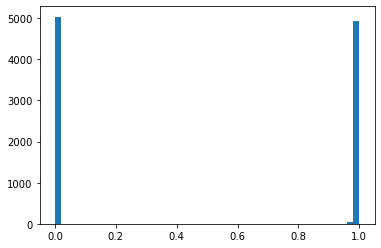

In [18]:
plt.hist(stability_factrs[0],bins=50)